In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
from IPython.display import Audio, HTML
from scipy.io import wavfile
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["figure.figsize"] = (14,4)
import librosa
from moviepy.editor import VideoFileClip, AudioFileClip, CompositeAudioClip
from matplotlib import cm

The goal function are get_info and get_gif, which can be changed for more interesting parameter searching and mappings. 

In [60]:
# take a look at the audio
audio_name = "data/Patti Austin - Thats Enough For Me.wav"
#audio_name = "data/snd.wav"
audio, sr = librosa.load(audio_name, sr=None)
if len(audio.shape) > 1: # if stereo, use only the left channel
    audio = audio.T[0]
audio = audio[0:10*sr] # keep max 10s of the audio
Audio(audio, rate=sr)

320x480


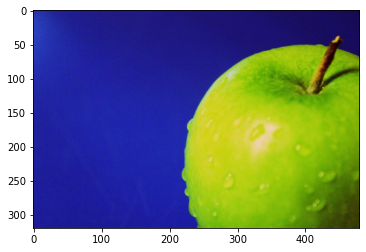

In [61]:
# take a look at the image
img = cv2.imread('data/apple.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def resize_image(img, target_width=480):
    height, width, layers = img.shape
    scale = target_width / width
    target_width = int(width * scale)
    target_height = int(height * scale)
    dim = (target_width, target_height)
    return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
img = resize_image(img)

plt.imshow(img)
print("{}x{}".format(*img.shape))

In [205]:
def normalize_frames(frames, norm_functions):
    return [
        { key: (norm_functions[key](value)
                if key in norm_functions else value)
         for key, value in frame.items() }
        for frame in frames
    ]

# function that takes audio as input and return different features
def get_info(audio_name, window_size):
    # audio_name -- name of audiofile
    # window_size -- we split audio into frames, this is the length of the frame in seconds
    x, sr = librosa.load(audio_name, sr = None)
    seconds = len(x) / sr
    frame_len = int(len(x) / (seconds / window_size))
    frames = []
    for ind in range(0, len(x) + 1, frame_len):
        current_amplitude = x[ind:ind + frame_len]
        fft = librosa.stft(current_amplitude, n_fft=len(current_amplitude), hop_length=len(current_amplitude))
        freqs = fft[:, 0]
        freqs = librosa.amplitude_to_db(abs(freqs))
        _, phase = librosa.magphase(fft)
        phase = phase[:, 0]
        frames.append({
            'amplitude':current_amplitude,
            'amplitude_abs_mean': np.mean(np.abs(current_amplitude)),
            'frequency':freqs,
            'phase':phase,
        })
        #timbre = 0
    print(len(frames))
    print(librosa.stft(x, n_fft=frame_len, hop_length = frame_len // 4))
    max_amplitude_mean = max(frame['amplitude_abs_mean'] for frame in frames)
    return normalize_frames(frames, {
        'amplitude_abs_mean': lambda x: x / max_amplitude_mean
    })

def get_features(audio, sr, window_size_s):
    x = audio
    features = {}
    frame_len = int(sr * window_size_s)
    hop_length = frame_len // 4
    n_frames = int(math.ceil(len(x) / hop_length))
    
    # stft
    stft = librosa.stft(x, n_fft=frame_len, hop_length = hop_length)
#    print(stft.shape, librosa.fft_frequencies(sr=sr, n_fft=frame_len).shape)
    features['stft'] = stft.T
    features['stft_db'] = librosa.amplitude_to_db(np.abs(stft)).T
    _, phase = librosa.magphase(stft)
    features['stft_phase'] = phase.T
    
    features['amplitude_abs_mean'] = []
    for i in range(n_frames):
        window = x[max(0, i*hop_length - frame_len//2) : i*hop_length + frame_len//2]
        features['amplitude_abs_mean'].append(np.mean(np.abs(window)))
    features['amplitude_abs_mean'] /= np.max(np.abs(features['amplitude_abs_mean']))
    
    # convert dict of lists to list of dicts
    return [dict(zip(features,t), 
                param_n_fft=frame_len
                ) for t in zip(*features.values())]

In [206]:
frames = get_features(audio, sr, 0.1)
frames[len(frames)//2]

{'stft': array([-3.7858202e+00+0.0000000e+00j,  1.1315097e+00-1.2726735e+00j,
         1.5569861e+00+1.0622617e+00j, ...,  2.6138980e-04-1.5268281e-04j,
        -3.0610163e-04+1.6193498e-04j,  5.2634842e-04+0.0000000e+00j],
       dtype=complex64),
 'stft_db': array([ 11.5632   ,   4.623998 ,   5.5054703, ..., -35.913006 ,
        -35.913006 , -35.913006 ], dtype=float32),
 'stft_phase': array([-1.        +1.5099580e-07j,  0.66444397-7.4733806e-01j,
         0.82605934+5.6358320e-01j, ...,  0.86348337-5.0437731e-01j,
        -0.8839297 +4.6761972e-01j,  1.        +0.0000000e+00j],
       dtype=complex64),
 'amplitude_abs_mean': 0.9269672,
 'param_n_fft': 4410}

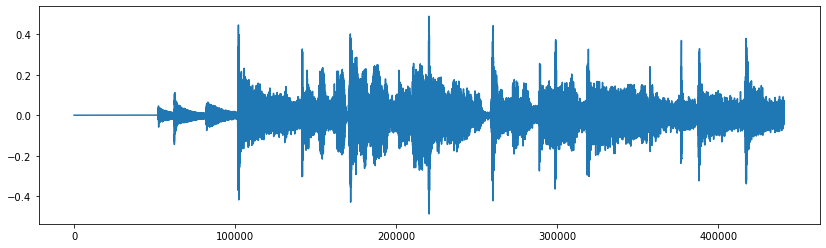

In [207]:
plt.plot(audio)

(0.0, 1.0)

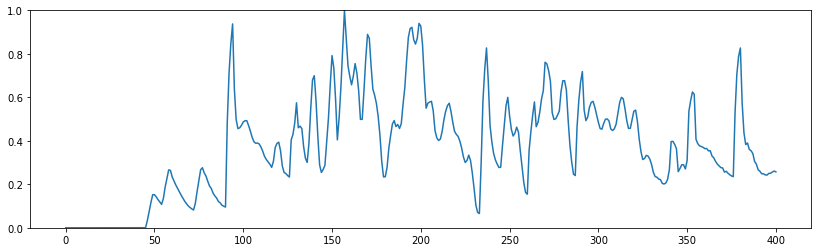

In [208]:
plt.plot([frame['amplitude_abs_mean'] for frame in frames])
plt.ylim((0,1))

In [282]:
# helper function that should be different for other approaches of mapping
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    new_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return new_img

def decrease_brightness(img, value=-30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = -value
    v[v < lim] = 0
    v[v >= lim] -= (-value)

    final_hsv = cv2.merge((h, s, v))
    new_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return new_img

def change_brightness(img, value=0):
    if value == 0:
        return img
    if value < 0:
        return decrease_brightness(img, value)
    return increase_brightness(img, value)

def change_brightness2(img, brightness_offset):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = np.clip(v + brightness_offset, 0, 255).astype('uint8')
    return cv2.cvtColor(cv2.merge((h, s, v)), cv2.COLOR_HSV2BGR)

In [284]:
def draw_shapes(img, features, t, sr):
    img = img.copy()
    h, w, _ = img.shape
    db_threshold = 8
    center_x, center_y = w//2, h//2
    
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=features['param_n_fft'])
    #print(len(frequencies), len(features['stft_db']))
    freq_min, freq_max = 30, 15000 # minimum and maximum frequencies to draw
    freq_indices = (frequencies >= freq_min) & (frequencies <= freq_max) # indices of frequencies to draw
    frequencies = frequencies[freq_indices]
    
    for i, val in enumerate(features['stft_db'][freq_indices]):
        magnitude = val - db_threshold
        if magnitude <= 0:
            continue
        freq = frequencies[i]
        rel_frequency = (np.log(freq) - np.log(freq_min)) / (np.log(freq_max) - np.log(freq_min)) # a number between 0 (=lowest frequency) and 1 (=highest frequency)
        center = (int(w * rel_frequency), int(h * rel_frequency))
        radius = int(min(h, w) * 0.03 * np.log(magnitude+1))
        rgba = np.array(cm.hsv(rel_frequency))*255
        rgba[3] = 100
        cv2.circle(img, center, radius, rgba, -1)
    return img

In [290]:
def get_image_frame(source_img, features, t, sr):
    #return change_brightness2(source_img, (features['amplitude_abs_mean'] - 0.5) * 1.8 * 255)
    img = source_img
    img = draw_shapes(img, features, t, sr)
    img = change_brightness2(img, (features['amplitude_abs_mean'] - 0.5) * 1.8 * 255)
    return img

def get_image_sequence(source_img, frames, sr):
    return [get_image_frame(source_img, frame, i/(len(frames)-1), sr) for i, frame in enumerate(frames)]

print("Generating {} images".format(len(frames)))
imgs = get_image_sequence(img, frames, sr)
print("Done")

Generating 401 images
Done


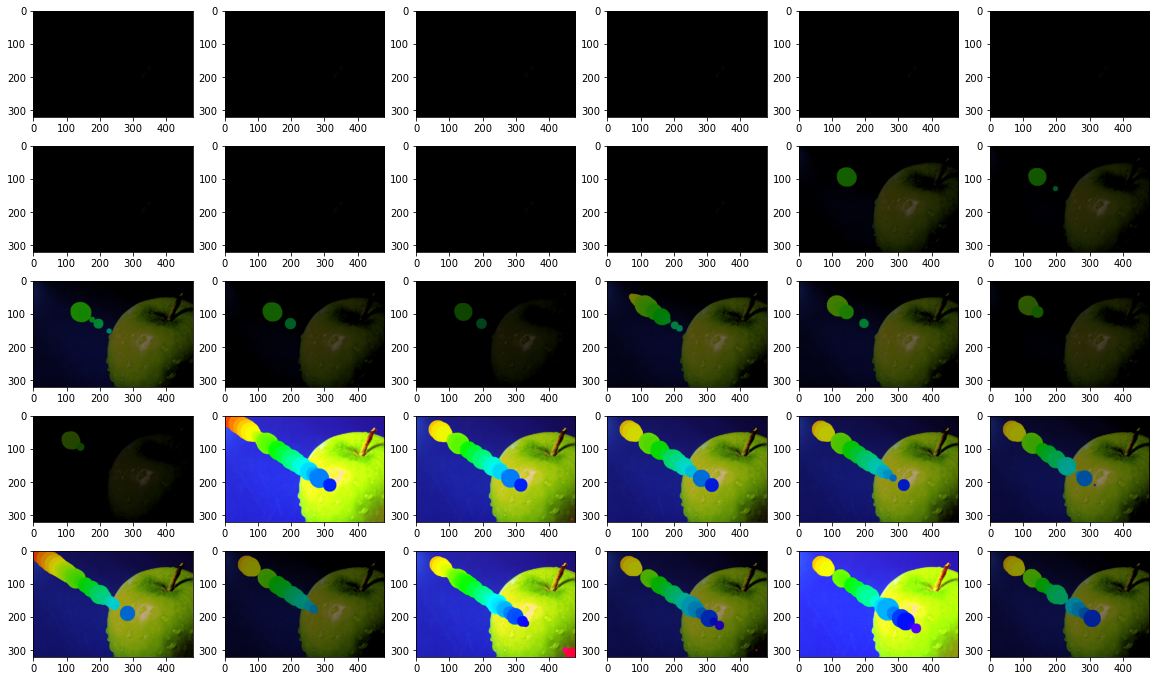

In [291]:
fig = plt.figure(figsize=(20, 12))
for i in range(min(30,len(imgs))):
    fig.add_subplot(5,6,i+1)
    plt.imshow(imgs[i*5])
plt.show()

In [292]:
def generate_video(imgs, fps, video_name, target_width=480):
    height, width, layers = imgs[0].shape
    video = cv2.VideoWriter(video_name, 0, fps, (width, height))
    for image in imgs:
        video.write(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    cv2.destroyAllWindows()
    video.release()

video_name = 'output.avi'
duration_s = len(audio) / sr
fps = len(imgs) / duration_s
generate_video(imgs, fps, video_name)

In [293]:
def merge_video_audio(video_name, fps, audio_name, video_out_name):
    # load the video
    video_clip = VideoFileClip(video_name)
    # load the audio
    audio_clip = AudioFileClip(audio_name)
    common_end = min(video_clip.end, audio_clip.end) # ends should be the same, just to be sure
    video_clip = video_clip.subclip(0, common_end)
    audio_clip = audio_clip.subclip(0, common_end)
    final_clip = video_clip.set_audio(audio_clip)
    final_clip.write_videofile(video_out_name, fps=fps)

video_out_name = "output2.mp4"
merge_video_audio(video_name, fps, audio_name, video_out_name)

Moviepy - Building video output2.mp4.
MoviePy - Writing audio in output2TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output2.mp4



Moviepy - Done !
Moviepy - video ready output2.mp4


In [294]:
HTML("""<video width="400" controls><source src="{}"></video>""".format(video_out_name))

---

In [9]:
# function that takes audio info and image as an imput an returns set of images for the frame
def get_gif(info, img_address):
    img = cv2.imread(img_address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ln = len(info)
    amplitudes = []
    for i in range(ln):
        amplitudes.append(info[i]['amplitude'].max())
    br_values = np.array(amplitudes) / min(amplitudes)
    # this arguments just hand picked, so the images looks different
    # for final version better use proper transformation
    a = 19.14
    b = -64.12
    br_values = br_values * a + b
    br_values = np.array(br_values, dtype=int)
    new_imgs = []
    for v in br_values:
        new_imgs.append(change_brightness(img, v))
    return new_imgs

In [10]:
new_imgs = get_gif(frames, 'AudioImagers/apple.jpg')

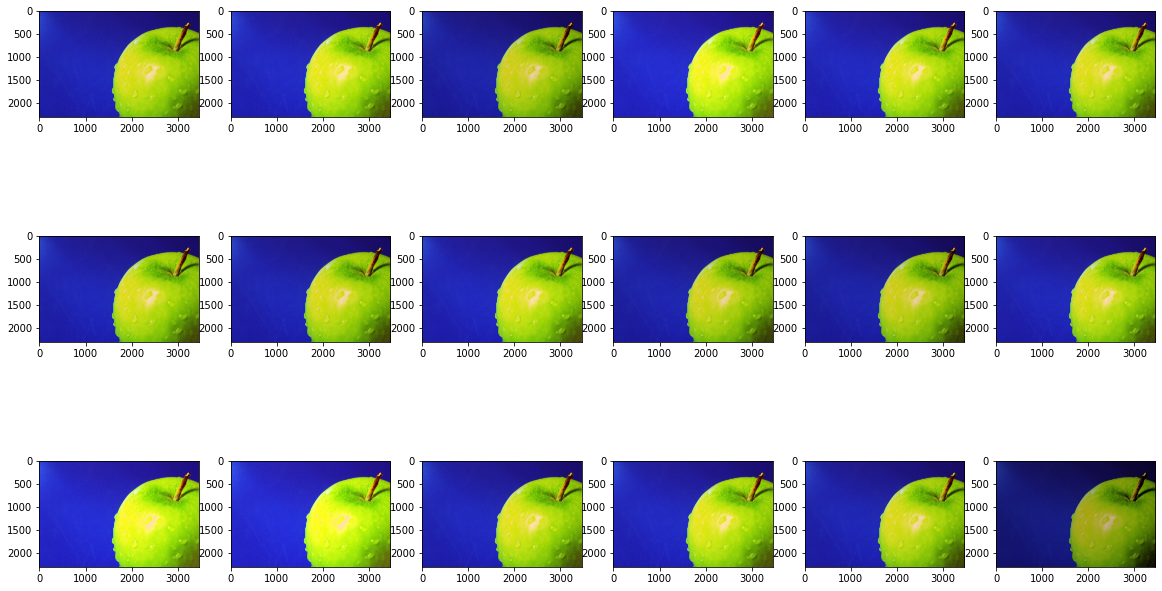

In [11]:
# basic visualization of images in result
fig = plt.figure(figsize=(20, 20))
for i in range(1,len(new_imgs)):
    fig.add_subplot(5,6,i)
    plt.imshow(new_imgs[i])
plt.show()

In [17]:
# this function is for making gif, the problem I didn't find an argument on how to change the time for particular image
# so, it will need additional coding
import imageio
with imageio.get_writer(f'out.gif', mode='I') as writer:
    for new_img in new_imgs:
        writer.append_data(new_img)

Gif saved



Also, here we should collect the similarity metrics vector. 
Approximately, it should look like that:
```
def img_metric(imgs):
    vec = []
    for i in range(len(imgs) - 1):
        vec.append(rmse(imgs[i], imgs[i + 1]))
    return vec
    
def audio_metric(frames):
    ...
    return some_vec

audio_vec = normalize(audio_metric...)
img_vec = normalize(img_metric...)
Goal_metric = cosine_distance(audio_vec, img_vec)
```

The goal is to make the best goal metric, which will be equal to similarity between vectors.